# Sentiment Classification on Tweets

#### This notebook provides brief insights on the preliminary analysis of the dataset!

In [2]:
%load_ext autoreload
%autoreload 2

## 1. Setup and Data Loading

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import re
import html
import time

sys.path.append(os.path.dirname(os.getcwd()))


from config import LABELS, setup_logger
from data.viz import get_histogram, kde_distribution, plot_wordclouds
from data.utils import TextCleaner, load_data

logger = setup_logger(__name__, "BLACK")

# Configuration
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]

# single-byte latin encoding. I tried using (UTF-8) but it wasnt properly encoding all the records in the dataset.
# this may lead to emojis not being properly recogized (replaced with �)
DATASET_ENCODING = "ISO-8859-1" 


# File paths
train_file = 'trainingandtestdata/training.1600000.processed.noemoticon.csv'
test_file = 'trainingandtestdata/testdata.manual.2009.06.14.csv'

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

/home/splion/Desktop/personal/projects/sentiment-analysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/splion/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Datasets

In [4]:
# Load training and test datasets
train_data = load_data(train_file, encoding=DATASET_ENCODING, columns=DATASET_COLUMNS)
test_data = load_data(test_file, encoding=DATASET_ENCODING, columns=DATASET_COLUMNS)

logger.info(f"Training Data size: {len(train_data):,}")
logger.info(f"Test Data size: {len(test_data):,}")
logger.info(f"\nDataset columns: {DATASET_COLUMNS}")
logger.info(f"Label mapping: {LABELS}")

2025-09-19 10:30:33,583 - data.utils - INFO - Dataset loaded from: trainingandtestdata/training.1600000.processed.noemoticon.csv with 1600000 rows
2025-09-19 10:30:33,586 - data.utils - INFO - Dataset loaded from: trainingandtestdata/testdata.manual.2009.06.14.csv with 498 rows
2025-09-19 10:30:33,587 - __main__ - INFO - Training Data size: 1,600,000
2025-09-19 10:30:33,587 - __main__ - INFO - Test Data size: 498
2025-09-19 10:30:33,588 - __main__ - INFO - 
Dataset columns: ['target', 'ids', 'date', 'flag', 'user', 'text']
2025-09-19 10:30:33,588 - __main__ - INFO - Label mapping: {0: 'NEGATIVE', 2: 'NEUTRAL', 4: 'POSITIVE'}


### Dataset Overview

In [5]:
# Display basic information about the datasets
print("=== TRAINING DATA OVERVIEW ===")
print(train_data.head())
print(f"\nUnique targets in training: {train_data['target'].unique().tolist()}")

print("\n=== TEST DATA OVERVIEW ===")
print(test_data.head())
print(f"\nUnique targets in test: {test_data['target'].unique().tolist()}")

=== TRAINING DATA OVERVIEW ===
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Unique targets in training: [0, 4]

=== TEST DATA OVERVIEW ===
   target  ids                          date     flag      user  \
0       4    3 

## 2. Class Distribution Analysis

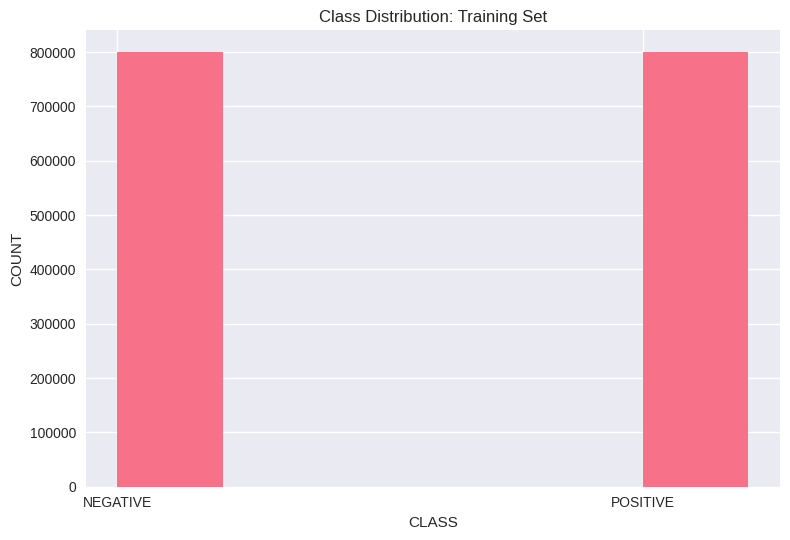

Training set class distribution:
  NEGATIVE: 800,000 (50.0%)
  POSITIVE: 800,000 (50.0%)


In [8]:
# Visualize class distributions 
fig, ax = get_histogram(np.asarray(train_data['target']), title='Training Set')
plt.tight_layout()
plt.show()

# Print exact counts
train_counts = train_data['target'].value_counts().sort_index()
print("Training set class distribution:")
for target, count in train_counts.items():
    print(f"  {LABELS[target]}: {count:,} ({count/len(train_data)*100:.1f}%)")

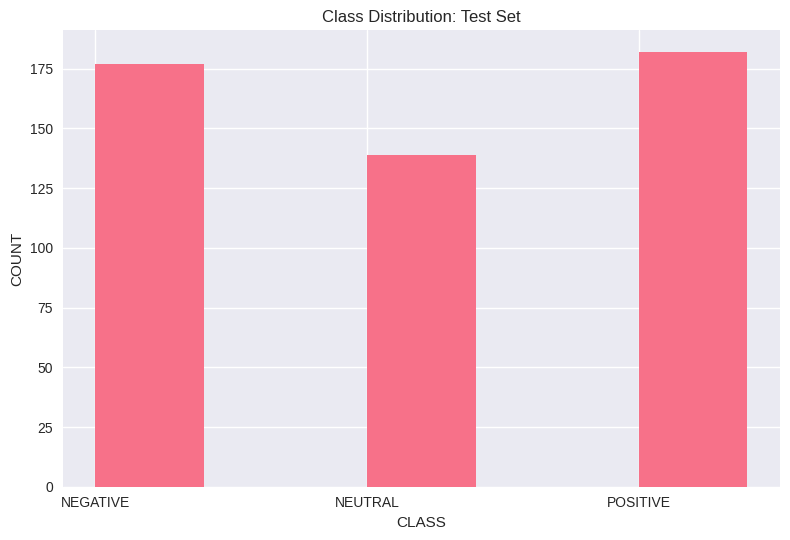

Test set class distribution:
  NEGATIVE: 177 (35.5%)
  NEUTRAL: 139 (27.9%)
  POSITIVE: 182 (36.5%)


In [7]:
# Test set distribution
fig, ax = get_histogram(np.asarray(test_data['target']), title='Test Set')
plt.tight_layout()
plt.show()

# Print exact counts
test_counts = test_data['target'].value_counts().sort_index()
print("Test set class distribution:")
for target, count in test_counts.items():
    print(f"  {LABELS[target]}: {count:,} ({count/len(test_data)*100:.1f}%)")

### Observations - Class Distribution

**Key Findings:**
- **Training set**: __Uniformly__ distributed with 800,000 Positive and 800,000 Pegative samples
- **Test set**: Contains three categories - Negative (177), __Neutral (139)__, and Positive (182)
- **Important**: The **NEUTRAL** category (label=2) only exists in the test set, not in training

**Assumptions for Model Training:**
- We can regard this as a **binary classification** problem (Positive vs Negative)
- Neutral samples in test set will be **excluded** during evaluation
- Balanced training data eliminates class imbalance concerns

## 3. Text Preprocessing and Cleaning

### Sample Text

In [9]:
# Examine sample tweets before and after cleaning
sample_indices = np.random.randint(0, len(train_data), size = 5)


print("=== SAMPLE TWEETS - BEFORE AND AFTER CLEANING ===")
for i, idx in enumerate(sample_indices, 1):
    original = train_data['text'].iloc[idx]
    cleaned = TextCleaner.clean_text(original)
    target = train_data['target'].iloc[idx]
    
    print(f"\n--- Sample {i} (Label: {LABELS[target]}) ---")
    print(f"ORIGINAL: {original}")
    print(f"CLEANED:  {cleaned}")
    print(f"Length change: {len(original)} → {len(cleaned)} chars")

=== SAMPLE TWEETS - BEFORE AND AFTER CLEANING ===

--- Sample 1 (Label: POSITIVE) ---
ORIGINAL: @karenabad Oh cool. I'll be in the city during pride... June 25 through the next week or so 
CLEANED:  oh cool ill be in the city during pride june 25 through the next week or so
Length change: 92 → 75 chars

--- Sample 2 (Label: NEGATIVE) ---
ORIGINAL: Sidekick is wiggin' out on me  Hit the iPhone!!
CLEANED:  sidekick is wiggin out on me hit the iphone
Length change: 47 → 43 chars

--- Sample 3 (Label: POSITIVE) ---
ORIGINAL: good morning!!!   just sent monte off, waiting for camille &amp; zack.......kelsey still sleeping.....call or text..........
CLEANED:  good morning just sent monte off waiting for camille amp zackkelsey still sleepingcall or text
Length change: 124 → 94 chars

--- Sample 4 (Label: POSITIVE) ---
ORIGINAL: @jasonely A bit more stable then can of gas I guess  Flame on!
CLEANED:  a bit more stable then can of gas i guess flame on
Length change: 62 → 50 chars

--- Sample 5 

### Text Cleaning

In [13]:
# Analyze what gets removed during cleaning
sample_texts = train_data['text'].tolist()
# sample_texts = train_data['text'].head(10000).tolist()

# Count various text patterns
url_count = sum(1 for text in sample_texts if TextCleaner.contains_url(text))
mention_count = sum(1 for text in sample_texts if TextCleaner.contains_mention(text))
email_count = sum(1 for text in sample_texts if TextCleaner.contains_email(text))
hashtag_count = sum(1 for text in sample_texts if TextCleaner.contains_hashtag(text))
punc_count = sum(1 for text in sample_texts if TextCleaner.contains_punctuation(text))

print(f"=== ANALYSIS (Sample of {len(sample_texts):,} tweets) ===")
print(f"Tweets with URLs: {url_count:,} ({url_count/len(sample_texts)*100:.3f}%)")
print(f"Tweets with @mentions: {mention_count:,} ({mention_count/len(sample_texts)*100:.3f}%)")
print(f"Tweets with emails: {email_count:,} ({email_count/len(sample_texts)*100:.3f}%)")
print(f"Tweets with hashtags: {hashtag_count:,} ({hashtag_count/len(sample_texts)*100:.3f}%)")
print(f"Tweets with punctuations: {punc_count:,} ({punc_count/len(sample_texts)*100:.3f}%)")

del sample_texts

=== ANALYSIS (Sample of 1,600,000 tweets) ===
Tweets with URLs: 70,156 (4.385%)
Tweets with @mentions: 738,493 (46.156%)
Tweets with emails: 558 (0.035%)
Tweets with hashtags: 35,847 (2.240%)
Tweets with punctuations: 1,449,132 (90.571%)


## Feature-Based Information Gain Analysis
Analyze which text features (mentions, hashtags, URLs, etc.) provide discriminative power between positive and negative sentiments. Information gain measures how much uncertainty is reduced when we know the presence/absence of a feature.

In [31]:
from viz import analyze_feature_distribution
def contains_emoticons(text):
    regex = re.compile(
    r"""
    (?:
        [<>]?
        [:;=8xX]             
        [\-o\*\']?          
        [\)\]\(\[dDpP/\:\}\{@\|\\]   
    )
    |
    (?:
        [\)\]\(\[dDpP/\:\}\{@\|\\]   
        [\-o\*\']?                   
        [:;=8xX]                     
        [<>]?
    )
    """,
    re.VERBOSE
)
    return bool(regex.search(text))

def contains_emojis(text): 
    regex = re.compile(
    "["
    "\U0001F600-\U0001F64F"  
    "\U0001F300-\U0001F5FF" 
    "\U0001F680-\U0001F6FF"  
    "\U0001F1E0-\U0001F1FF"  
    "\U00002700-\U000027BF"  
    "\U0001F900-\U0001F9FF"  
    "\U00002600-\U000026FF"  
    "\U00002B00-\U00002BFF" 
    "]+"
)
    return bool(regex.search(text))

features_to_analyze = [
    (TextCleaner.contains_url, "URLs"),
    (TextCleaner.contains_mention, "Mentions (@)"),
    (TextCleaner.contains_hashtag, "Hashtags (#)"),
    (TextCleaner.contains_email, "Email addresses"),
    (lambda text: '!' in text, "Exclamation marks"),
    (lambda text: '?' in text, "Question marks"),
    (lambda text: any(char.isupper() for char in text), "Capital letters"),
    (contains_emoticons, "Emoticons"), 
    (contains_emojis, "Emojis (should be 0)")
]




results = []
for feature_func, feature_name in features_to_analyze:
    result = analyze_feature_distribution(train_data, feature_func, feature_name)
    results.append(result)

results.sort(key=lambda x: x['information_gain'], reverse=True)


print(f"{'Feature':<25} {'Pos%':<8} {'Neg%':<8} {'Info Gain%':<12}")
print("-" * 80)

for result in results:

    print(f"{result['feature']:<25} "
          f"{result['pos_percentage']:<8.2f} "
          f"{result['neg_percentage']:<8.2f} "
          f"{result['information_gain']*100:<12.6f} "
         )


Feature                   Pos%     Neg%     Info Gain%  
--------------------------------------------------------------------------------
Mentions (@)              54.71    37.61    2.132900     
Exclamation marks         35.38    24.79    0.964438     
URLs                      5.77     3.00     0.337179     
Emoticons                 12.30    8.91     0.220210     
Capital letters           78.03    74.80    0.104384     
Hashtags (#)              2.58     1.90     0.037949     
Email addresses           0.06     0.01     0.010417     
Question marks            10.76    10.15    0.007162     
Emojis (should be 0)      0.00     0.00     0.000000     


### Observations - Information Gain Analysis
- The information gain analysis reveal that the above mentioned features do not possess significant information gain on splitting.
- Thereby, we can conclude that some of most of the above mentioned features can be removed without any potential __information loss__

### Apply Cleaning to Full Dataset

In [17]:
# Clean the full training dataset 
print("Cleaning training dataset...")
train_data['cleaned_text'] = TextCleaner.clean_texts_parallel(train_data['text'].tolist())

print("Cleaning test dataset...")
test_data['cleaned_text'] = TextCleaner.clean_texts_parallel(test_data['text'].tolist())

print("Text cleaning completed!")

2025-09-19 10:37:10,881 - data.utils - INFO - Cleaning 1600000 texts using 16 workers...


Cleaning training dataset...


Cleaning batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 47.47batches/s]
2025-09-19 10:37:12,899 - data.utils - INFO - Cleaning 498 texts using 16 workers...


Cleaning test dataset...


Cleaning batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:00<00:00, 33561.89batches/s]

Text cleaning completed!


## 4. Text Length Analysis

In [18]:
# Calculate text lengths (characters and words)
train_data['char_len'] = train_data['cleaned_text'].apply(len)
train_data['word_count'] = train_data['cleaned_text'].apply(lambda x: len(x.split()))

# Display statistics
print("=== TEXT LENGTH STATISTICS ===")
print("\nCharacter Length:")
print(train_data['char_len'].describe())

print("\nWord Count (Cleaned):")
print(train_data['word_count'].describe())

=== TEXT LENGTH STATISTICS ===

Character Length:
count    1.600000e+06
mean     6.220972e+01
std      3.422049e+01
min      0.000000e+00
25%      3.400000e+01
50%      5.700000e+01
75%      8.900000e+01
max      3.490000e+02
Name: char_len, dtype: float64

Word Count (Cleaned):
count    1.600000e+06
mean     1.247968e+01
std      6.898782e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.100000e+01
75%      1.800000e+01
max      4.000000e+01
Name: word_count, dtype: float64


### Word Count Distribution (KDE)

2025-09-19 10:37:27,604 - data.viz - INFO - KDE plot created for 1600000 text samples


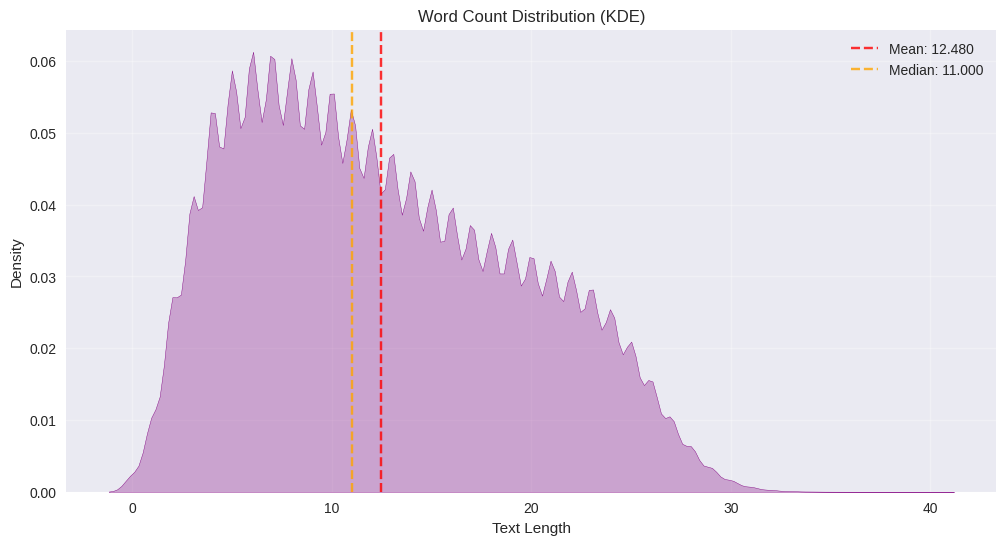


=== WORD COUNT PERCENTILES (for max_length decisions) ===
50th percentile: 11.0 words
75th percentile: 18.0 words
90th percentile: 23.0 words
95th percentile: 25.0 words
99th percentile: 28.0 words


In [19]:
# Create KDE plot for word distribution (the words here are inferred from splitting the text)
# NOT TOKENIZED

fig, ax = kde_distribution(
    train_data['word_count'].tolist(),
    title='Word Count Distribution (KDE)',
    figsize=(12, 6),
    color='purple'
)
plt.show()

percentiles = [50, 75, 90, 95, 99]
print("\n=== WORD COUNT PERCENTILES (for max_length decisions) ===")
for p in percentiles:
    value = np.percentile(train_data['word_count'], p)
    print(f"{p}th percentile: {value:.1f} words")

### Observations - Text Length Analysis

**Key Insights:**
- Text cleaning reduces average character length, removing noise like URLs and mentions
- The percentile analysis helps determine optimal `MAX_LENGTH` for tokenization. We can observe that $99\%$ of texts have a word length $\leq 28$ 

## 5. Word Frequency and Vocabulary Analysis

### Word Clouds
<p>Provides us a way to visualize the most frequntly appearing words in the whole corpus</p>

Positive texts: 800,000
Negative texts: 800,000

Generating word clouds from 800,000 positive and 800,000 negative samples...


2025-09-19 10:39:15,691 - data.viz - INFO - Wordclouds created from 800000 positive             and 800000 negative texts


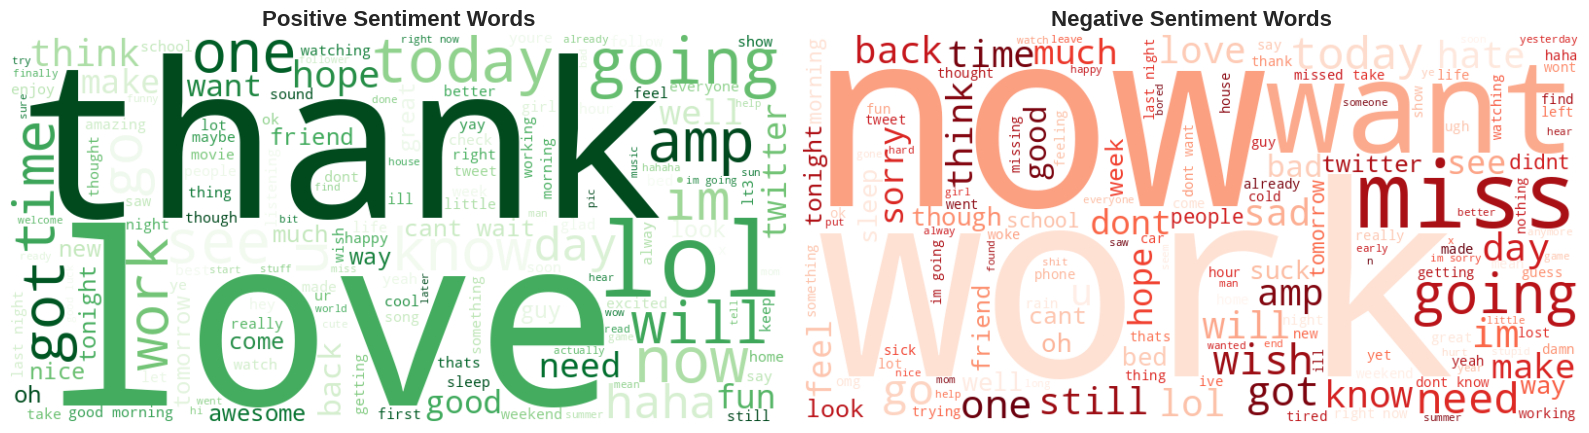

In [21]:
positive_texts = train_data[train_data['target'] == 4]['cleaned_text'].tolist()
negative_texts = train_data[train_data['target'] == 0]['cleaned_text'].tolist()

print(f"Positive texts: {len(positive_texts):,}")
print(f"Negative texts: {len(negative_texts):,}")

sample_size = len(train_data)  # Use subset for wordcloud (compute constraints)
pos_sample = positive_texts[:sample_size]
neg_sample = negative_texts[:sample_size]

print(f"\nGenerating word clouds from {len(pos_sample):,} positive and {len(neg_sample):,} negative samples...")

fig, axes = plot_wordclouds(
    pos_sample, 
    neg_sample,
    figsize=(16, 8),
    max_words=150,
    background_color='white'
)
plt.show()

### Most Frequent Words by Sentiment

In [23]:
from collections import Counter
import string
import spacy
nlp = spacy.load('en_core_web_sm')
stop_words = set(nlp.Defaults.stop_words) # Get all the stopwords

def get_top_words(texts, k=20, min_length=3):
    all_words = []
    for text in texts:
        words = text.lower().split()
        filtered_words = [
            word.strip(string.punctuation) 
            for word in words 
            if len(word.strip(string.punctuation)) >= min_length
            and word.strip(string.punctuation).isalpha() and word not in stop_words
        ]
        all_words.extend(filtered_words)
    
    return Counter(all_words).most_common(k)

sample_size = 100000
k = 20
pos_top_words = get_top_words(positive_texts[:sample_size], k)
neg_top_words = get_top_words(negative_texts[:sample_size], k)

print(f"=== TOP {k} WORDS BY SENTIMENT ===")
print("\nPOSITIVE SENTIMENT:")
for word, count in pos_top_words:
    print(f"  {word}: {count:,}", end="")

print("\nNEGATIVE SENTIMENT:")
for word, count in neg_top_words:
    print(f"  {word}: {count:,}", end="")

=== TOP 20 WORDS BY SENTIMENT ===

POSITIVE SENTIMENT:
  good: 7,882  love: 5,506  day: 5,265  like: 4,760  thanks: 4,292  going: 4,056  lol: 3,831  time: 3,774  today: 3,644  great: 3,337  got: 3,284  new: 3,275  know: 3,144  night: 3,022  twitter: 2,873  morning: 2,856  dont: 2,810  amp: 2,590  think: 2,509  work: 2,393
NEGATIVE SENTIMENT:
  work: 6,282  day: 5,595  cant: 5,400  dont: 5,318  like: 4,925  today: 4,762  going: 4,352  got: 4,068  want: 3,692  good: 3,669  time: 3,527  miss: 3,189  sad: 3,154  home: 2,983  know: 2,937  sleep: 2,801  wish: 2,798  need: 2,794  night: 2,698  think: 2,641

### Vocabulary Size 

In [24]:
from encoders import TweetTokenizer 
from collections import Counter


tokenizer = TweetTokenizer()
sample_texts = train_data['cleaned_text'].head(200000).tolist()
print(f"Analyzing vocabulary from {len(sample_texts):,} samples...")

start_time = time.time()
all_tokens = []
for text in sample_texts:
    tokens = tokenizer.tokenize(text)
    all_tokens.extend(tokens)

vocab_counter = Counter(all_tokens)
total_tokens = len(all_tokens)
unique_tokens = len(vocab_counter)

print(f"\n=== VOCABULARY STATISTICS ===")
print(f"Total tokens: {total_tokens:,}")
print(f"Unique tokens: {unique_tokens:,}")
print(f"Vocabulary diversity: {unique_tokens/total_tokens:.4f}")

print(f"Time taken: {time.time()-start_time:.3f} s")

[nltk_data] Downloading package wordnet to /home/splion/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Analyzing vocabulary from 200,000 samples...

=== VOCABULARY STATISTICS ===
Total tokens: 2,611,078
Unique tokens: 80,512
Vocabulary diversity: 0.0308
Time taken: 30.033 s


In [25]:
from encoders import BPETokenizer
from collections import Counter


tokenizer = BPETokenizer()
sample_texts = train_data['cleaned_text'].head(200000).tolist()
print(f"Analyzing vocabulary from {len(sample_texts):,} samples...")

start_time = time.time()
all_tokens = []
for text in sample_texts:
    tokens = tokenizer.tokenize(text)
    all_tokens.extend(tokens)

vocab_counter = Counter(all_tokens)
total_tokens = len(all_tokens)
unique_tokens = len(vocab_counter)

print(f"\n=== VOCABULARY STATISTICS ===")
print(f"Total tokens: {total_tokens:,}")
print(f"Unique tokens: {unique_tokens:,}")
print(f"Vocabulary diversity: {unique_tokens/total_tokens:.4f}")
print(f"Time taken: {time.time()-start_time:.3f} s")

2025-09-19 10:41:09,536 - encoders - INFO - Loaded BPE tokenizer from /home/splion/Desktop/personal/projects/sentiment-analysis/data/toks/bpe.json


Analyzing vocabulary from 200,000 samples...

=== VOCABULARY STATISTICS ===
Total tokens: 3,168,386
Unique tokens: 28,119
Vocabulary diversity: 0.0089
Time taken: 6.104 s


In [26]:
from encoders import GPT2Tokenizer
from collections import Counter


tokenizer = GPT2Tokenizer()
sample_texts = train_data['cleaned_text'].head(200000).tolist()
print(f"Analyzing vocabulary from {len(sample_texts):,} samples...")

start_time = time.time()
all_tokens = []
for text in sample_texts:
    tokens = tokenizer.tokenize(text)
    all_tokens.extend(tokens)

vocab_counter = Counter(all_tokens)
total_tokens = len(all_tokens)
unique_tokens = len(vocab_counter)

print(f"\n=== VOCABULARY STATISTICS ===")
print(f"Total tokens: {total_tokens:,}")
print(f"Unique tokens: {unique_tokens:,}")
print(f"Vocabulary diversity: {unique_tokens/total_tokens:.4f}")
print(f"Time taken: {time.time()-start_time:.3f} s")

Analyzing vocabulary from 200,000 samples...

=== VOCABULARY STATISTICS ===
Total tokens: 3,010,182
Unique tokens: 24,621
Vocabulary diversity: 0.0082
Time taken: 8.507 s


### Observations - Vocabulary Analysis

**Word Cloud:**
- **Positive words**: Dominated by expressions of joy, appreciation, and positive experiences
- **Negative words**: Filled with complaints, negative emotions, and problematic situations

**Vocabulary Statistics:**
If we look closely at the individual tokenizers, we can construe that,
- __BPE__ has the best __token__ reuse efficiency (~ 120x compression, 8.562s for 200,000 texts), followed by __GPT2__ with (~90x compression, 11.7s for 200,000 texts)
- __Tweet__ is the _worst_ in terms of reuse & speed (around 28s for 200,000 texts) but has the _best_ token coverage (22 %) among considered tokenizers

## 6. Tokenization Preview

### Sample Tokenization Examples

In [27]:
# Demonstrate tokenization on sample tweets
sample_tweets = [
    "I love this amazing product! It works perfectly :)",
    "This is terrible... worst experience ever!!!",
    "@user thanks for the help #grateful",
    "Check out this link: https://example.com"
]

tokenizer = TweetTokenizer() #GPT2Tokenizer() BPETokenizer() TweetTokenizer()
print("=== TOKENIZATION EXAMPLES ===")
for i, tweet in enumerate(sample_tweets, 1):
    original = tweet
    cleaned = TextCleaner.clean_text(tweet)
    tokens = tokenizer.tokenize(cleaned)
    
    print(f"\n--- Example {i} ---")
    print(f"Original:  {original}")
    print(f"Cleaned:   {cleaned}")
    print(f"Tokens:    {tokens}")
    print(f"Token count: {len(tokens)}")

=== TOKENIZATION EXAMPLES ===

--- Example 1 ---
Original:  I love this amazing product! It works perfectly :)
Cleaned:   i love this amazing product it works perfectly
Tokens:    ['i', 'love', 'this', 'amaz', 'product', 'it', 'work', 'perfect']
Token count: 8

--- Example 2 ---
Original:  This is terrible... worst experience ever!!!
Cleaned:   this is terrible worst experience ever
Tokens:    ['this', 'is', 'terribl', 'worst', 'experi', 'ever']
Token count: 6

--- Example 3 ---
Original:  @user thanks for the help #grateful
Cleaned:   thanks for the help
Tokens:    ['thank', 'for', 'the', 'help']
Token count: 4

--- Example 4 ---
Original:  Check out this link: https://example.com
Cleaned:   check out this link
Tokens:    ['check', 'out', 'this', 'link']
Token count: 4


### Token Length Distribution for Model Design

Calculating token lengths for 50,000 samples...


2025-09-19 10:41:28,399 - data.viz - INFO - KDE plot created for 50000 text samples


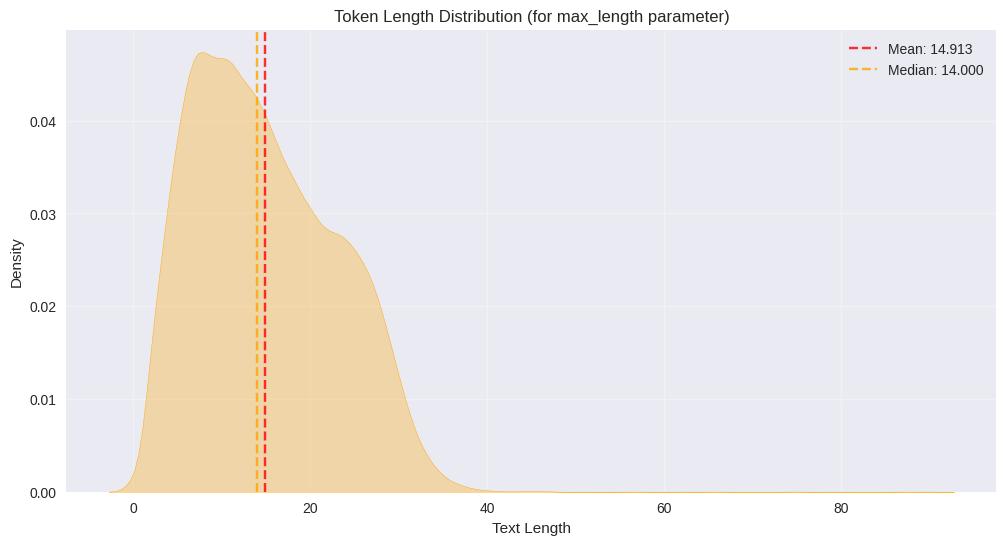


=== TOKEN LENGTH PERCENTILES (for max_length parameter) ===
50th percentile: 14.0 tokens
75th percentile: 21.0 tokens
90th percentile: 26.0 tokens
95th percentile: 29.0 tokens
99th percentile: 33.0 tokens
(40 tokens): covers ~99.9% of samples


In [28]:
from config import MAX_LENGTH
tokenizer = GPT2Tokenizer() #GPT2Tokenizer() BPETokenizer() TweetTokenizer()
sample_for_tokens = train_data['cleaned_text'].head(50000).tolist()
token_lengths = []

print(f"Calculating token lengths for {len(sample_for_tokens):,} samples...")
for text in sample_for_tokens:
    tokens = tokenizer.tokenize(text)
    token_lengths.append(len(tokens))

# Create KDE plot for token lengths
fig, ax = kde_distribution(
    token_lengths,
    title='Token Length Distribution (for max_length parameter)',
    figsize=(12, 6),
    color='orange'
)
plt.show()


print("\n=== TOKEN LENGTH PERCENTILES (for max_length parameter) ===")
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    value = np.percentile(token_lengths, p)
    print(f"{p}th percentile: {value:.1f} tokens")
print(f"({MAX_LENGTH} tokens): covers ~{sum(1 for l in token_lengths if l <= 40)/len(token_lengths)*100:.1f}% of samples")

In [29]:
### Lets check out the OOV rate (misses / hits)
from data.encoders import TweetTokenizer, BPETokenizer, GPT2Tokenizer
import random
from viz import validate_tokenizer



sample_size = 5000
sample_texts = train_data['text'].sample(sample_size, random_state=42).tolist()
tokenizers = {
    'Tweet': (TweetTokenizer(), TweetTokenizer().fetch_vocab),
    'BPE': (BPETokenizer(), BPETokenizer().fetch_vocab), 
    'GPT-2': (GPT2Tokenizer(), GPT2Tokenizer().fetch_vocab)
}

results = []
for name, (tokenizer, vocab) in tokenizers.items():
    if vocab is not None:  
        result = validate_tokenizer(sample_texts, name, tokenizer, vocab)
        results.append(result)
    else:
        print(f"\n{name} tokenizer vocabulary not found")


print("\n" + "="*42)
print("SUMMARY")
print("="*42)
print(f"{'Tokenizer':<12} {'OOV Rate':<10} {'Chars/Token':<12} {'Vocab Size':<12}")
print("-" * 42)

for result in results:
    print(f"{result['tokenizer']:<12} {result['oov_rate']:<10.3f} {result['chars_per_token']:<12.2f} "
          f"{result['vocab_size']:<12,}")

2025-09-19 10:41:28,577 - data.encoders - INFO - Loading vocabulary from /home/splion/Desktop/personal/projects/sentiment-analysis/data/toks/tweet_vocab.json
2025-09-19 10:41:28,619 - data.encoders - INFO - Loaded BPE tokenizer from /home/splion/Desktop/personal/projects/sentiment-analysis/data/toks/bpe.json
2025-09-19 10:41:28,656 - data.encoders - INFO - Loaded BPE tokenizer from /home/splion/Desktop/personal/projects/sentiment-analysis/data/toks/bpe.json
2025-09-19 10:41:28,657 - data.encoders - INFO - Loading vocabulary from /home/splion/Desktop/personal/projects/sentiment-analysis/data/toks/bpe_vocab.json
2025-09-19 10:41:29,427 - data.encoders - INFO - Loading vocabulary from /home/splion/Desktop/personal/projects/sentiment-analysis/data/toks/gpt2_vocab.json
2025-09-19 10:41:29,457 - viz - INFO - 
=== TWEET TOKENIZER ANALYSIS ===
2025-09-19 10:41:30,261 - viz - INFO - Out-of-Vocabulary Rate: 2.252%
2025-09-19 10:41:30,275 - viz - INFO - 
Pattern-specific OOV rates:
2025-09-19 10:


SUMMARY
Tokenizer    OOV Rate   Chars/Token  Vocab Size  
------------------------------------------
Tweet        2.252      5.01         30,000      
BPE          0.000      3.34         30,000      
GPT-2        0.000      3.47         50,258      


## 7. Preprocessing Pipeline Validation

In [30]:
import re
from data.utils import TextCleaner

def preprocess_ablation_study(texts, sample_size=5000):
    sample_texts = texts[:sample_size] if len(texts) > sample_size else texts
    def remove_urls(text):
        return TextCleaner._URL_REGEX.sub('', text)
    
    def remove_mentions(text):
        return TextCleaner._MENTION_REGEX.sub('', text)
    
    def remove_hashtags(text):
        return TextCleaner._HASHTAG_REGEX.sub('', text)
    
    def remove_emails(text):
        return TextCleaner._EMAIL_REGEX.sub('', text)
    
    def normalize_whitespace(text):
        return re.sub(r'\s+', ' ', text).strip()
    
    preprocessing_configs = {
        'No preprocessing': lambda x: x,
        'Only URL removal': lambda x: TextCleaner.remove_whitespace(TextCleaner.remove_urls(x)),
        'Only mention removal': lambda x: TextCleaner.remove_whitespace(TextCleaner.remove_mentions(x)),
        'Only hashtag removal': lambda x: TextCleaner.remove_whitespace(TextCleaner.remove_hashtags(x)),
        'Only email removal': lambda x: TextCleaner.remove_whitespace(TextCleaner.remove_emails(x)),
        'URL + Mentions': lambda x: TextCleaner.remove_whitespace(TextCleaner.remove_urls(TextCleaner.remove_mentions(x))),
        'URL + Mentions + Hashtags': lambda x: TextCleaner.remove_whitespace(TextCleaner.remove_hashtags(TextCleaner.remove_mentions(TextCleaner.remove_urls(x)))),
        'All': lambda x: TextCleaner.clean_text(x),
    }
    

    results = []
    
    for config_name, preprocess_func in preprocessing_configs.items():
        print(f"Testing: {config_name}")
        
        processed_texts = [preprocess_func(text) for text in sample_texts]
        
  
        original_lengths = [len(text) for text in sample_texts]
        processed_lengths = [len(text) for text in processed_texts]
        

        avg_original_length = np.mean(original_lengths)
        avg_processed_length = np.mean(processed_lengths)
        length_reduction_pct = ((avg_original_length - avg_processed_length) / avg_original_length) * 100
        
        original_vocab = set()
        processed_vocab = set()
        
        for orig, proc in zip(sample_texts, processed_texts):
            original_vocab.update(orig.lower().split())
            processed_vocab.update(proc.lower().split())
        
        vocab_reduction_pct = ((len(original_vocab) - len(processed_vocab)) / len(original_vocab)) * 100 if original_vocab else 0

        content_overlap = []
        for orig, proc in zip(sample_texts, processed_texts):
            if len(orig) > 0:
                overlap = len(set(orig.lower()) & set(proc.lower())) / len(set(orig.lower()))
                content_overlap.append(overlap)
        
        avg_content_preservation = np.mean(content_overlap) * 100 if content_overlap else 0
        
        original_special_chars = sum(sum(1 for c in text if not c.isalnum() and not c.isspace()) for text in sample_texts)
        processed_special_chars = sum(sum(1 for c in text if not c.isalnum() and not c.isspace()) for text in processed_texts)
        noise_reduction_pct = ((original_special_chars - processed_special_chars) / original_special_chars) * 100 if original_special_chars > 0 else 0
        
        results.append({
            'config': config_name,
            'length_reduction': length_reduction_pct,
            'vocab_reduction': vocab_reduction_pct,
            'content_preservation': avg_content_preservation,
            'noise_reduction': noise_reduction_pct,
            'avg_length': avg_processed_length,
            'vocab_size': len(processed_vocab)
        })
    
    return results

ablation_results = preprocess_ablation_study(train_data['text'].tolist(), sample_size=8000)

print(f"\n{'='*100}")
print("PREPROCESSING IMPACT ANALYSIS")
print(f"{'='*100}")
print(f"{'Configuration':<30} {'Length↓':<10} {'Vocab↓':<10} {'Content↑':<12} {'Noise↓':<10} {'Final Len':<10}")
print("-" * 100)

for result in ablation_results:
    print(f"{result['config']:<30} "
          f"{result['length_reduction']:<10.1f}% "
          f"{result['vocab_reduction']:<10.1f}% "
          f"{result['content_preservation']:<12.1f}% "
          f"{result['noise_reduction']:<10.1f}% "
          f"{result['avg_length']:<10.1f}")


Testing: No preprocessing
Testing: Only URL removal
Testing: Only mention removal
Testing: Only hashtag removal
Testing: Only email removal
Testing: URL + Mentions
Testing: URL + Mentions + Hashtags
Testing: All

PREPROCESSING IMPACT ANALYSIS
Configuration                  Length↓    Vocab↓     Content↑     Noise↓     Final Len 
----------------------------------------------------------------------------------------------------
No preprocessing               0.0       % 0.0       % 100.0       % 0.0       % 74.5      
Only URL removal               2.7       % 1.0       % 99.2        % 4.7       % 72.5      
Only mention removal           7.2       % 12.3      % 95.1        % 10.6      % 69.1      
Only hashtag removal           1.8       % 0.5       % 99.8        % 0.5       % 73.2      
Only email removal             1.6       % 0.0       % 100.0       % 0.0       % 73.3      
URL + Mentions                 8.4       % 13.3      % 94.3        % 15.3      % 68.3      
URL + Mentions +

## 8. Final Insights and Recommendations

### Key Findings:

1. **Dataset Characteristics**:
   - 1.6M balanced training samples (50% positive, 50% negative)
   - Test set includes neutral class that will be __excluded__ during evaluation
   - Twitter-specific language patterns with URLs, mentions, and informal text

2. **Text Processing Impact**:
   - Cleaning removes ~13-15% (on average) of original text length
   - Eliminates noise while preserving sentiment-relevant content
   - Reduces vocabulary complexity while maintaining meaning

3. **Vocabulary Insights**:
   - __BPE__ achieves the highest vocabulary efficiency through optimal token reuse, making it well-suited for production environments with computational constraints
   - Despite __Tweet__ tokenizer's enhanced coverage and potential performance advantages over custom-trained __BPE__, the __BPE__ approach offers better _generalization_ and _robustness_ for unseen text patterns

4. **Model Design Implications**:
   - Token length analysis supports __MAX_LENGTH__ as a valid padding length 
   - Vocabulary size of 30K provides good coverage with manageable complexity